### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Saturday, Mar 2nd at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (10 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

In [2]:
#importing tools
import numpy as np
import scipy
import matplotlib.pyplot as plt

### Part 1

In [183]:
#Read in `hw5_data_1.npy`. This is a (10 x 3) numpy array, containing some time-series measurements. 
#It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), 
#the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. 
#Plot this data with the uncertainties.


#Reading in the data
data = np.load('/home/nowickr/astr_8070_s24/coursework/homeworks/hw_data/hw5_data_1.npy')
print(data)

[[ 0.46954762  8.83485016  1.        ]
 [ 1.87898004 10.90082649  1.        ]
 [ 2.01075462 10.46566244  1.        ]
 [ 2.02183974  8.46375631  1.        ]
 [ 3.91877923 11.48825219  1.        ]
 [ 6.02254716 11.89588918  1.        ]
 [ 6.41474963 11.17877957  1.        ]
 [ 7.10360582  9.82007516  1.        ]
 [ 8.71292997  8.92924738  1.        ]
 [ 9.39405108 11.05445173  1.        ]
 [ 9.60984079  9.59682305  1.        ]
 [ 9.71012758 11.22244507  1.        ]
 [10.20448107 10.20827498  1.        ]
 [11.03751412 10.97663904  1.        ]
 [11.82744259 10.3563664   1.        ]
 [11.8727719  10.70657317  1.        ]
 [12.01965612 10.01050002  1.        ]
 [12.89262977 11.78587049  1.        ]
 [13.17978624 10.12691209  1.        ]
 [13.81829513 10.40198936  1.        ]
 [14.33532874 11.8831507   1.        ]
 [15.89695836  8.65224094  1.        ]
 [16.13095179  8.729515    1.        ]
 [18.3191362  10.96939671  1.        ]
 [19.65823617  8.82687659  1.        ]
 [20.88767561 11.94362119

Text(0.5, 1.0, 'Flux Over Time with Homoscedastic Error')

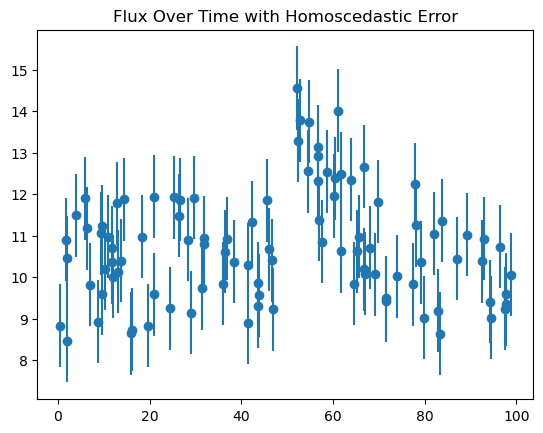

In [184]:
#plotting data with uncertainties

#setting columns as variables
t = data[:,0]           #time
flux = data[:,1]        #flux
sigma_fl = data[:,2]    #flux uncertainty


#plotting
plt.scatter(t,flux)
plt.errorbar(x=t,y=flux,yerr=sigma_fl, fmt='None')
plt.title('Flux Over Time with Homoscedastic Error')

### Part 2

One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$
$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.


In [185]:
#Code this burst model, and code a likelihood function for this data with the burst model. 
#*Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

#defining model as a function
def exp_burst_model(t,t0,b,A,alpha):
    if t<t0:
        y = b
    if t>=t0:
        y = b + A*np.exp(-alpha*(t-t0))
    return y

#defining a likelihood function for some data and a given model
def likelihood(data,model):
    like = []                       #empty list to insert calculated likelihoods over time
    for i in range(len(data)):      #iterating over all time values
        L = (1/2)*np.sum((data-i)**2/(sigma**2))           #likelihood calculation
        like.append(L)              #append likelihood to list
    return like

In [186]:
#defining test spaces for variables
t0_grid  = np.linspace(0,10,1000)
b_grid   = np.linspace(0,10,1000)
A_grid   = np.linspace(0,10,1000)
alp_grid = np.linspace(0,10,1000)

In [187]:
#testing my functions

In [193]:
def exp_burst_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For a polynomial with order 1, this gives theta_0 + theta_1*x
    # For a polynomial with order 2, this gives theta_0 + theta_1*x + theta_2*x^2, etc.
    #return sum(t * x ** n for (n, t) in enumerate(theta))
    b = theta[0]
    A = theta[1]
    t0 = theta[2]
    alpha = theta[3]
    for i in t:
        if i<t0:
            return b
        if i>=t0:
            return b + A*np.exp(-alpha*(t-t0))
    


In [194]:
#functional for exponential burst fit model
def exp_burst_fit(theta, x):
    for b,A,t0,alpha in theta:
        if t<t0:
            return b
        if t>=t0:
            return b + A*np.exp(-alpha*(t-t0))

In [166]:
def exp_burst_fit(theta, x):
    if t<t0:
        return b
    if t>=t0:
        return b + A*np.exp(-alpha*(t-t0))

In [190]:
# compute the data log-likelihood given a model
def logL(theta, data, model=exp_burst_fit):
    #"""Gaussian log-likelihood of the model at theta"""
    #separating data into columns
    x = data[:,0]
    y = data[:,1]
    sigma_y = data[:,2]
    #fitting model
    y_fit = exp_burst_fit(theta, x)
    return sum(scipy.stats.norm.logpdf(*args) 
               for args in zip(y, y_fit, sigma_y))

### Part 3

In [195]:
#Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain 
# of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. 
#For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

#Making Priors
b_prior = scipy.stats.uniform(0,50)         #low bound 0, width 50 = high bound 50
A_prior = scipy.stats.uniform(0,100)        #low bound 0, width 100 = high bound 100
t0_prior = scipy.stats.uniform(0,100)       #low bound 0, width 100 = high bound 100
alpha_prior = scipy.stats.uniform(-5,10)    #low bound -5, width 10 = high bound 5

In [ ]:
#starting mcmc chain

#using PTMCMC
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc #importing PTMCMC

#building parts for MCMC:
# dimension of parameter space
ndim = 4 #dimensions are b, A, t0, alpha
# initial jump covariance matrix
cov = np.diag(np.ones(ndim))    #array of 4 dimensions filled with ones, made diagonal

#defining function of priors to be used in findng the posterior
def logPrior()
    ???
    combo_prior = b_prior * A_prior * t0_prior * alpha_prior
    return combo_prior

# intialize sampler for posterior
sampler = ptmcmc(ndim, logLikelihood, logPrior, cov,    #number of dimensions, log likelihood, priors, initial covariance matrix
                 outDir='./my_ptmcmc_chain', resume=False)



### Part 4

### Part 5

### Part 6

### Part 7